# Studying language change in Icelandic parliamentary speeches

Our task involves research into language change over the past 100 years. Additionally we have been tasked with working out factors that influence language change. 

Another proposed research question involves figuring out which languages are going extinct. This particular task has been found out to be near impossible to answer given the available data. It is estimated to be very hard to come up with data that capture the amount of speakers for a large enough ranges of combinations of language and year. Furthermore, any data that are available are likely to apply a different definition of "speaker" (sometimes including second/third... language speakers, sometimes not) and is also likely to contain politically motivated noise.

In [1]:
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET

Therefore we decided to search for English language corpora containing a wide array of text documents collected over the past century for predefined dialects of English and genre of text (movie, articles, books, ...). This surprisingly turned out to be a complex endeavour as all high quality corpora were available only for a big price tag. 

We also looked into the material provided by the Guttenberg Project [Link](https://www.projekt-gutenberg.org/). This turned out to be promising at first sight as it appears that there is a lot of recently published material. However release date of these documents does not match the year when the documents were actually written and soon enough we figured out that all material is from before 1923. This obviously did not allow us to look much into language change of the 20th and 21st century.

_Gerlach, M., & Font-Clos, F. (2020). A standardized Project Gutenberg corpus for statistical analysis of natural language and quantitative linguistics. Entropy, 22(1), 126._

Theoretically one could obtain books from after 1923 and include them into the analysis. But one would quickly run into copyright/licensing issues here.

Obtaining the content of these books and preprocessing them for the purposes of data analysis turned out to be quite cumbersome as well. Look at Gunnar's notebooks (first draft [here](firstDraft.ipynb), second draft [here](secondDraft.ipynb)) for the details. 

Finally we turned to looking for non-English corpora and found an annotated corpus including pre-factured lemmatization of [Icelandic parlimentary speeches](https://clarin.is/en/resources/parliament/) from 1911 until 2018:

_Steingrímsson, Steinþór, Sigrún Helgadóttir, Eiríkur Rögnvaldsson, Starkaður Barkarson and Jón Guðnason. 2018. Risamálheild: A Very Large Icelandic Text Corpus. Proceedings of LREC 2018, pp. 4361-4366. Myazaki, Japan._

In [2]:
namespace = "{http://www.tei-c.org/ns/1.0}"

## Get the data

Download data from here: http://www.malfong.is/index.php?dlid=81&lang=en

Then extract zip folder such that a folder labelled `CC_BY` shows up in the parent folder of this notebook. *Test*: `ls ../CC_BY/althingi` should work when run from `.../IcelandicParliamentSpeeches.ipynb`.

## Preprocessing helpers

The data are available as XML. The text has already been preprocessed to be separated into paragraphs, sentences and words. Furthermore each word tag also includes a `lemma` attribute relating inflected/declensed forms of words to its lemma. This has been done by the authors of the original paper using Machine Learning approaches.

Given a relative path to a file, pull out a list with all the words. This can be achieved by looking for all tags of type `w`, additionally also retrieve the lemma for each word.

We will discard all sentences of length 3 or smaller to remove noise and to avoid that our models are able to detect year of speech just based on some short introductory/outro phrases. Furthermore the raw data appear to contain plenty of elements tagged as words that comprise of just a single letter followed by a dot. These will be removed here as well.

⚠️ *Pitfall*: The namespace from above must be included when parsing out content from these XML files based on tag names.

⚠️ In this kind of preprocessing we lose information about sentence boundaries as all punctuation items from the raw data are dropped.

In [3]:
def extract_words(path):
    xml_tree = ET.parse(open(path, 'r'))
    words = []
    lemmata = []
    
    for sentence in xml_tree.getroot().iter('{}s'.format(namespace)):
        words_in_sent = sentence.findall('{}w'.format(namespace))
        if len(words_in_sent) > 2:
            for word in sentence.findall('{}w'.format(namespace)):
                if not word.text.endswith('.'):
                    words.append(word.text)
                    lemmata.append(word.attrib['lemma'])
        
    return words, lemmata

Extract content of files separated into sentences, note that all stop items are wrapped in a `p` tag in the original documents and are not included here.

Also note that some further pre-processing could be done here to exclude items such as numbers, percentages, names, abbreviations, etc. In the original documents these are also assigned to be words:

In [4]:
def extract_sentences(path, lemma=False):
    xml_tree = ET.parse(open(path, 'r'))
    sentences = []
    
    for sentence in xml_tree.getroot().iter('{}s'.format(namespace)):
        sentence_cur = []
        words_in_sent = sentence.findall('{}w'.format(namespace))
        
        if len(words_in_sent) > 2:
            for word in sentence.findall('{}w'.format(namespace)):
                if not word.text.endswith('.'):
                    if lemma:
                        sentence_cur.append(word.attrib['lemma'])
                    else:
                        sentence_cur.append(word.text)
            
            sentences.append(sentence_cur)
        
    return sentences

Retrieve a random selection of `k` file names from the entire corpus. The files must be of type `xml`. This method does not load the entire corpus into memory and allows you to work with smaller selections for test purposes. This method samples only from the `althingi` folder so far:

In [5]:
import glob

def get_random_sample(k):
    files = [filename for filename in glob.iglob('../CC_BY/althingi/**/*.xml', 
                                                 recursive=True)]
    return random.sample(files, k)

Do the same as above but choose `k` files only from a given year (range: 1911-2017)

In [6]:
def get_files_for_year(year, k):
    files = [filename for filename in glob.iglob('../CC_BY/althingi/{}/'.format(year) + '**/*.xml', 
                                                 recursive=True)]
    return random.sample(files, min(len(files), k))

## Data analysis

Doing some basic analysis on the documents in this section.

### Zipf's Law

First using frequency distributions of the Natural Language ToolKit (`NLTK`) to look into whether or not we can confirm [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law) based on the data we have.

⚠️ Note that the analysis is done based on 15 randomly selected files from the entire corpus at this point:

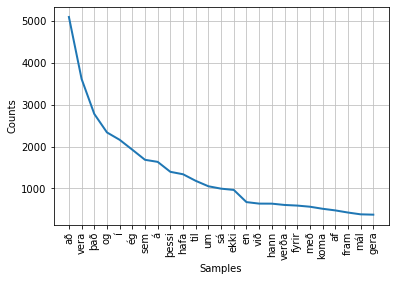

In [7]:
from nltk.probability import FreqDist
import random

words = []

for file in get_random_sample(150):
    words.extend(extract_words(file)[1])
    
fq = FreqDist(word.lower() for word in words)
fq.plot(25, cumulative=False)

Visualizing the same data but with using the logarithm of the occurrences, this should ideally obtain a straight line:

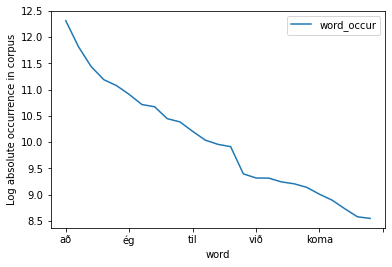

In [8]:
freq_df = pd.DataFrame.from_dict(fq, orient='index', columns=['word_occur'])
freq_df.sort_values(by='word_occur', inplace=True, ascending=False)
freq_df.word_occur = np.log2(freq_df['word_occur'])
freq_df.head(25).plot(kind='line', xlabel='word', ylabel='Log absolute occurrence in corpus')

### Disappearing words / new words

In [9]:
words_1914 = []
words_2014 = []

for file in get_files_for_year(1914, 25):
    words_1914.extend(extract_words(file)[1])
    
for file in get_files_for_year(2014, 25):
    words_2014.extend(extract_words(file)[1])

### Development of average sentence length

This is just one possible metric for the development/analysis of language complexity. There is so much more you could come up with here.

Obviously our choice to discard very short sentences in the preprocessing step has an impact on the values here:

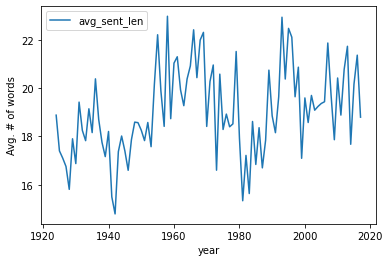

In [10]:
from functools import reduce

def avg_sentence_length_year(year, k):
    sentence_len = []
    for file in get_files_for_year(year, k):
        sentences = extract_sentences(file)
        sentence_len.extend([len(s) for s in sentences])
    
    return reduce(lambda a, b: a + b, sentence_len) / len(sentence_len)
        
sentence_len_years = []

for year in range(1924, 2018):
    sentence_len_years.append(avg_sentence_length_year(year, 20))
    
avg_df = pd.DataFrame(sentence_len_years, index=range(1924, 2018), columns=['avg_sent_len'])
avg_df.plot(kind='line', xlabel='year', ylabel='Avg. # of words')

### n-grams

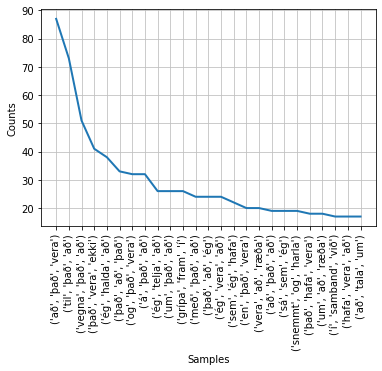

In [11]:
from nltk import ngrams

def most_common_ngrams(n, top_k, sample):
    file_contents = []

    for file in get_random_sample(sample):
        file_contents.extend(extract_words(file)[1])
    
    fq_ngr = FreqDist(ngrams(file_contents, n))
    fq_ngr.plot(top_k, cumulative=False)
    
most_common_ngrams(n=3, top_k=25, sample=100)

## Building model for classifying speeches



Using a simple model now, the steps of the pipeline include:

- Create TF-IDF matrix, which provides normalized frequency scores for words: https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
- Reduce to the `k` "best" (or, most influential) words
- Run Naive Bayes

Plenty of things that can be parametrized here, just adapt the `parameters` dict and/or or `pipeline` object below.

Alternative pipelines also evaluate the performance of `Word2Vec` (with or without a combination with TF-IDF) and `Doc2Vec`, both of which are explained in further detail below.

### Constructing training data

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator

file_contents = []
targets = []

for year in [1914, 1912, 
             1933, 1936, 1939, 1938, 1934,
             1954, 1955, 1957, 1959, 1956,
             1975, 1978, 1972, 1971, 1977,
             1992, 1995, 1999, 1997, 1993,
             2014, 2015, 2013, 2016, 2012]:
    for file in get_files_for_year(year, 100):
        file_contents.append(extract_words(file)[1])
        targets.append(year - year%10)

Let's randomly choose a fixed number of documents (here currently: 50) from various different decades. Then passing (document, decade) pairs to the model below. The decade is computed by subtracting `mod(<year>, 10)` from `<year>`.

#### TF-IDF

In [13]:
class JoinElement(object):
    def fit(self, X, y):
        return self

    def transform(self, X):
        return [' '.join(X[i]) for i in range(len(X))]

#### Word2Vec

<ins>Original paper</ins>:
Mikolov, T., Sutskever, I., Chen, K., Corrado, G. S., & Dean, J. (2013). Distributed representations of words and phrases and their compositionality. Advances in neural information processing systems, 26, 3111-3119.

With this model every word is assigned a unique vector of configurable cardinality such that the dot product of two randomly chosen vectors should be proportional to the semantic similarity for the associated words. This happens during the training step using logistic regression and sliding windows. Personally I found that this video delivers a solid explanation of the concepts: https://www.youtube.com/watch?v=QyrUentbkvw

However, since we are working with entire documents as training items we have to somehow aggregate the vectors for every word in a given document. This can be done e.g. by taking the mean and/or summing up the vectors (see `MeanEmbeddingVectorizer`), optionally weighted by TF-IDF (see `MeanEmbeddingVectorizerTfidf`).

In [14]:
from gensim.models import Word2Vec

class MeanEmbeddingVectorizer(BaseEstimator):
    def fit(self, X, y):
        self.word2vec = Word2Vec(X)
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.wv[w] for w in words if w in self.word2vec.wv.vocab]
                    or [np.zeros(self.word2vec.vector_size)], axis=0)
            for words in X
        ])
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [15]:
class MeanEmbeddingVectorizerTfidf(BaseEstimator):
    def fit(self, X, y):
        self.word2vec = Word2Vec(X)
        self.X_joined = [' '.join(X[i]) for i in range(len(X))]
        self.vectorizer = TfidfVectorizer()
        self.transformed = self.vectorizer.fit_transform(self.X_joined)
        self.transformed = pd.DataFrame.sparse.from_spmatrix(self.transformed)
        return self
    
    def tfidf(self, w, docid):
        if w in self.vectorizer.vocabulary_:
            return self.transformed[self.vectorizer.vocabulary_[w]][docid]
        else:
            return 0

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec.wv[w] * self.tfidf(w, i) for w in words if w in self.word2vec.wv.vocab]
                    or [np.zeros(self.word2vec.vector_size)], axis=0)
            for i, words in enumerate(X)
        ])
    
    def fit_transform(self, X, y):
        self = self.fit(X, y)
        return self.transform(X)

#### Doc2Vec

Finally we are attempting to build a model using _Doc2Vec_. After training this model with our training corpus we receive a vector of configurable cardinality for each document.

<ins>Original paper</ins>: Le, Quoc, and Tomas Mikolov. "Distributed representations of sentences and documents." International conference on machine learning. 2014.

In [16]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

class Doc2Vectorizer(BaseEstimator):
    def __init__(self, window=2, vector_size=100):
        self.window = window
        self.vector_size = vector_size
        
    def fit(self, X, y):
        docs = [TaggedDocument(X[i], [i]) for i in range(len(X))]
        self.doc_vec = Doc2Vec(docs, vector_size=self.vector_size, window=self.window, min_count=1, workers=4)
        return self

    def transform(self, X):
        return [self.doc_vec.infer_vector(X[i]) for i in range(len(X))]

Attempting to produce a visualization of the Doc2Vec model based on our training corpus after running a PCA to reduce dimensionality down to levels where a vis could be feasible:

In [17]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

docs = [TaggedDocument(file_contents[i], [i]) for i in range(len(file_contents))]
doc_vec = Doc2Vec(docs, vector_size=100, window=5, min_count=1, workers=4)

pca_docs = PCA(n_components = 2).fit_transform(doc_vec.docvecs.vectors_docs)

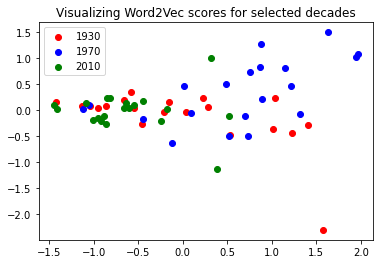

In [18]:
from random import sample

colors = ['red', 'blue', 'green']
decades = [1930, 1970, 2010]

for i, decade in enumerate(decades):
    indices = sample(np.nonzero(np.array(targets) == decade)[0].tolist(), 20)
    plt.scatter(pca_docs[indices, 0], 
                pca_docs[indices, 1], 
                color=colors[i])
    plt.legend(decades)
    plt.title('Visualizing Word2Vec scores for selected decades')

**BERT** (*Bidirectional Encoder Representations from Transformers*) is also interesting to look at, but we'll skip this here because we predict training a model from scratch would use up too many resources. Given more time however you could search for pretrained networks that roughly serve the purpose of classification of documents according to publication year.

<ins>Paper</ins>: Devlin, J., Chang, M. W., Lee, K., & Toutanova, K. (2018). Bert: Pre-training of deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805.

### Defining and training the model

In [33]:
from pprint import pprint
from time import time
import logging

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_selection import SelectKBest, chi2


parameters_tfidf = {}
parameters_word2vec = {}
parameters_doc2vec = {
    'doc2vec__window': [4],
    'doc2vec__vector_size': [300]
}


def run_tfidf():
    pipeline_tfidf = Pipeline([
        ('join', JoinElement()),
        ('tfidf', TfidfVectorizer()),
        ('k_best', SelectKBest(chi2, k=1000)),
        ('log', RandomForestClassifier())
    ])
    
    grid_search_tfidf = GridSearchCV(pipeline_tfidf, parameters_tfidf, verbose=1)
    grid_search_tfidf.fit(file_contents, targets)
    return grid_search_tfidf


def run_word2vec():
    pipeline_word2vec = Pipeline([
        ('tfidf', MeanEmbeddingVectorizer()),
        ('log', LogisticRegression())
    ])
    
    grid_search_word2vec = GridSearchCV(pipeline_word2vec, parameters_word2vec, verbose=1)
    grid_search_word2vec.fit(file_contents, targets)
    return grid_search_word2vec


def run_doc2vec():
    pipeline_doc2vec = Pipeline([
        ('doc2vec', Doc2Vectorizer()),
        ('log', RandomForestClassifier())
    ])
    
    grid_search_doc2vec = GridSearchCV(pipeline_doc2vec, parameters_doc2vec, verbose=1)
    grid_search_doc2vec.fit(file_contents, targets)
    return grid_search_doc2vec


grid_search_tfidf = run_tfidf()
grid_search_word2vec = run_word2vec()
grid_search_doc2vec = run_doc2vec()

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.1s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.7min finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.1min finished


### Testing the model

Choosing a fixed number of random documents from the same six years and check if the decade is correctly predicted by the model, note that we are treating `year` more like a classification label than some continuous variable:

💡 Run the two chunks again to apply a different test set and inspect predictions:

In [34]:
from sklearn.metrics import accuracy_score

file_contents_test = []
targets_test = []

for year in [1911, 1937, 1958, 1973, 1994, 2017]:
    for file in get_files_for_year(year, 20):
        file_contents_test.append(extract_words(file)[1])
        targets_test.append(year - year%10)

In [35]:
from sklearn.metrics import plot_confusion_matrix

def eval_(estimator):
    fig, ax = plt.subplots(figsize=(10, 10))
    plot_confusion_matrix(estimator=estimator, X=file_contents_test, y_true=targets_test, ax=ax)
    preds = estimator.predict(file_contents_test)
    accuracy = accuracy_score(y_true=targets_test, y_pred=estimator.predict(file_contents_test))
    print(accuracy)

0.6833333333333333


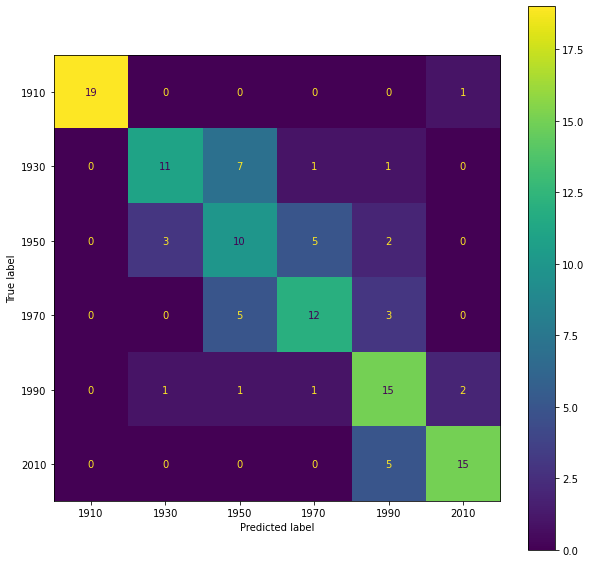

In [36]:
eval_(grid_search_tfidf.best_estimator_)

0.16666666666666666


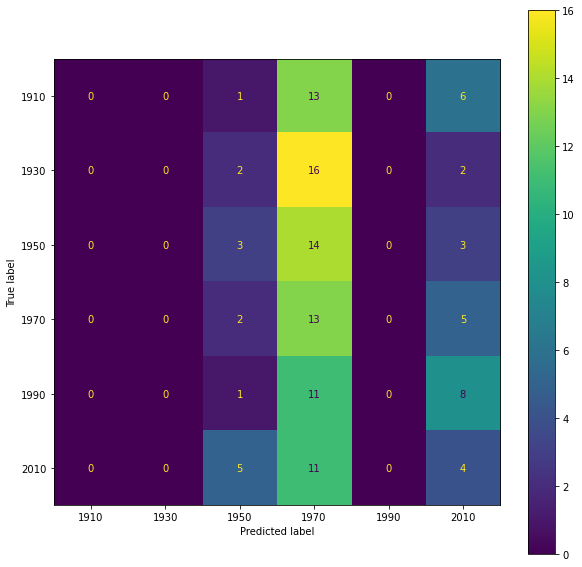

In [37]:
eval_(grid_search_word2vec.best_estimator_)

0.35833333333333334


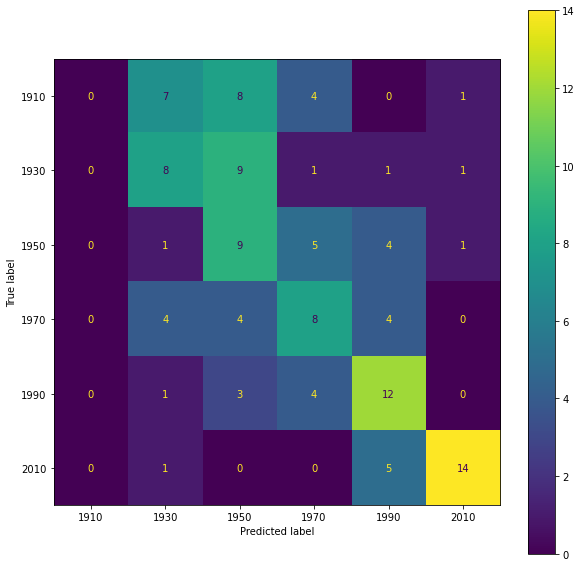

In [38]:
eval_(grid_search_doc2vec.best_estimator_)

Not great not terrible!

From my couple first runs it appears as if TF-IDF works well also with small data sets. When using larger corpora for training the models Word2Vec and Doc2Vec start to pick up. However, both of them take considerably larger amount of time to fit than TF-IDF.